In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import h5py
import pickle
import numpy as np
import torch
import torch_interpolations as torchitp
from torchquad import Simpson, set_up_backend
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import quad
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import spat_ori_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imsh, cax=cax, orientation='vertical')

# Read itp.h5, Extract Ranges and E/I Moment Values

In [3]:
def extract_moments(file):
    f = h5py.File(file, 'r')
    
    ranges_dict = {}
    for key in ['Ph','M','C','PhL','ML','CL']:
        ranges_dict[key] = {}
        ranges_dict[key]['xrange'] = list(f[key+'Itp']['xrange'])
    for key in ['M','C','ML','CL']:
        ranges_dict[key]['σrange'] = list(f[key+'Itp']['srange'])
    for key in ['C','CL']:
        ranges_dict[key]['crange'] = list(f[key+'Itp']['crange'])
        
    with open('./../results/itp_ranges'+'.pkl', 'wb') as handle:
        pickle.dump(ranges_dict,handle)
        
    for key in ['Ph','M','C']:
        for idx,ctype in enumerate(['E','I']):
            np.save('./../results/'+key+ctype+'_itp',
                    np.array(f[key+'Itp']['rp'+str(idx+1)][key+'s']).astype(np.float32))

extract_moments('itp.h5')

# From Ranges and E/I Moment Values, Interpolate Moments

In [4]:
def μtox(μ):
    return np.sign(μ/100-0.2)*np.abs(μ/100-0.2)**0.5

def xtoμ(x):
    return 100*(np.sign(x)*np.abs(x)**2.0+0.2)
    
def itp_moments():
    with open('./../results/itp_ranges'+'.pkl', 'rb') as handle:
        ranges_dict = pickle.load(handle)
    
    φxrange = ranges_dict['Ph']['xrange']
    φxs = np.linspace(φxrange[0],φxrange[1],round(φxrange[2])).astype(np.float32)
    φEs = np.load('./../results/PhE_itp.npy').astype(np.float32)
    φIs = np.load('./../results/PhI_itp.npy').astype(np.float32)
    
    Mxrange = ranges_dict['M']['xrange']
    Mxs = np.linspace(Mxrange[0],Mxrange[1],round(Mxrange[2])).astype(np.float32)
    Mσrange = ranges_dict['M']['σrange']
    Mσs = np.linspace(Mσrange[0],Mσrange[1],round(Mσrange[2])).astype(np.float32)
    MEs = np.load('./../results/ME_itp.npy').astype(np.float32)
    MIs = np.load('./../results/MI_itp.npy').astype(np.float32)
    
    Cxrange = ranges_dict['C']['xrange']
    Cxs = np.linspace(Cxrange[0],Cxrange[1],round(Cxrange[2])).astype(np.float32)
    Cσrange = ranges_dict['C']['σrange']
    Cσs = np.linspace(Cσrange[0],Cσrange[1],round(Cσrange[2])).astype(np.float32)
    Ccrange = ranges_dict['C']['crange']
    Ccs = np.linspace(Ccrange[0],Ccrange[1],round(Ccrange[2])).astype(np.float32)
    CEs = np.load('./../results/CE_itp.npy').astype(np.float32)
    CIs = np.load('./../results/CI_itp.npy').astype(np.float32)
    
    φE_itp = RegularGridInterpolator((φxs,),φEs,bounds_error=False,fill_value=None)
    φI_itp = RegularGridInterpolator((φxs,),φIs,bounds_error=False,fill_value=None)
    
    ME_itp = RegularGridInterpolator((Mσs,Mxs),MEs,bounds_error=False,fill_value=None)
    MI_itp = RegularGridInterpolator((Mσs,Mxs),MIs,bounds_error=False,fill_value=None)
    
    CE_itp = RegularGridInterpolator((Ccs,Cσs,Cxs),CEs,bounds_error=False,fill_value=None)
    CI_itp = RegularGridInterpolator((Ccs,Cσs,Cxs),CIs,bounds_error=False,fill_value=None)
    
    base_itp_dict = {}
    base_itp_dict['φE_itp'] = φE_itp
    base_itp_dict['φI_itp'] = φI_itp
    base_itp_dict['ME_itp'] = ME_itp
    base_itp_dict['MI_itp'] = MI_itp
    base_itp_dict['CE_itp'] = CE_itp
    base_itp_dict['CI_itp'] = CI_itp
    
    with open('base_itp'+'.pkl', 'wb') as handle:
        pickle.dump(base_itp_dict,handle)
    
    def φE(μ):
        try:
            return φE_itp(μtox(1e3*μ)[:,None])
        except:
            return φE_itp([μtox(1e3*μ)])
    def φI(μ):
        try:
            return φI_itp(μtox(1e3*μ)[:,None])
        except:
            return φI_itp([μtox(1e3*μ)])
    
    def ME(μ,Σ):
        return ME_itp(np.row_stack(list(np.broadcast(1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    def MI(μ,Σ):
        return MI_itp(np.row_stack(list(np.broadcast(1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    
    def CE(μ,Σ,k):
        c = np.sign(k)*np.fmin(np.abs(k)/Σ,1)
        return CE_itp(np.row_stack(list(np.broadcast(c,1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    def CI(μ,Σ,k):
        c = np.sign(k)*np.fmin(np.abs(k)/Σ,1)
        return CI_itp(np.row_stack(list(np.broadcast(c,1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    
    return φE,φI,ME,MI,CE,CI

In [5]:
def μtox_torch(μ):
    return torch.sign(μ/100-0.2)*torch.abs(μ/100-0.2)**0.5

def xtoμ_torch(x):
    return 100*(torch.sign(x)*torch.abs(x)**2.0+0.2)

def itp_moments_torch():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    with open('./../results/itp_ranges'+'.pkl', 'rb') as handle:
        ranges_dict = pickle.load(handle)
    
    φxrange = ranges_dict['Ph']['xrange']
    φxs = np.linspace(φxrange[0],φxrange[1],round(φxrange[2])).astype(np.float32)
    φEs = np.load('./../results/PhE_itp.npy').astype(np.float32)
    φIs = np.load('./../results/PhI_itp.npy').astype(np.float32)
    φxs_torch = torch.from_numpy(φxs).to(device)
    φEs_torch = torch.from_numpy(φEs).to(device)
    φIs_torch = torch.from_numpy(φIs).to(device)

    Mxrange = ranges_dict['M']['xrange']
    Mxs = np.linspace(Mxrange[0],Mxrange[1],round(Mxrange[2])).astype(np.float32)
    Mσrange = ranges_dict['M']['σrange']
    Mσs = np.linspace(Mσrange[0],Mσrange[1],round(Mσrange[2])).astype(np.float32)
    MEs = np.load('./../results/ME_itp.npy').astype(np.float32)
    MIs = np.load('./../results/MI_itp.npy').astype(np.float32)
    Mxs_torch = torch.from_numpy(Mxs).to(device)
    Mσs_torch = torch.from_numpy(Mσs).to(device)
    MEs_torch = torch.from_numpy(MEs).to(device)
    MIs_torch = torch.from_numpy(MIs).to(device)

    Cxrange = ranges_dict['C']['xrange']
    Cxs = np.linspace(Cxrange[0],Cxrange[1],round(Cxrange[2])).astype(np.float32)
    Cσrange = ranges_dict['C']['σrange']
    Cσs = np.linspace(Cσrange[0],Cσrange[1],round(Cσrange[2])).astype(np.float32)
    Ccrange = ranges_dict['C']['crange']
    Ccs = np.linspace(Ccrange[0],Ccrange[1],round(Ccrange[2])).astype(np.float32)
    CEs = np.load('./../results/CE_itp.npy').astype(np.float32)
    CIs = np.load('./../results/CI_itp.npy').astype(np.float32)
    Cxs_torch = torch.from_numpy(Cxs).to(device)
    Cσs_torch = torch.from_numpy(Cσs).to(device)
    Ccs_torch = torch.from_numpy(Ccs).to(device)
    CEs_torch = torch.from_numpy(CEs).to(device)
    CIs_torch = torch.from_numpy(CIs).to(device)

    φE_itp = torchitp.RegularGridInterpolator((φxs_torch,),φEs_torch)
    φI_itp = torchitp.RegularGridInterpolator((φxs_torch,),φIs_torch)

    ME_itp = torchitp.RegularGridInterpolator((Mσs_torch,Mxs_torch),MEs_torch)
    MI_itp = torchitp.RegularGridInterpolator((Mσs_torch,Mxs_torch),MIs_torch)

    CE_itp = torchitp.RegularGridInterpolator((Ccs_torch,Cσs_torch,Cxs_torch),CEs_torch)
    CI_itp = torchitp.RegularGridInterpolator((Ccs_torch,Cσs_torch,Cxs_torch),CIs_torch)
    
    def φE(μ):
        try:
            return φE_itp(μtox_torch(1e3*μ)[None,:])
        except:
            return φE_itp(torch.tensor([μtox_torch(1e3*μ)]))
    def φI(μ):
        try:
            return φI_itp(μtox_torch(1e3*μ)[None,:])
        except:
            return φI_itp(torch.tensor([μtox_torch(1e3*μ)]))

    def ME(μ,Σ):
        try:
            return ME_itp(torch.row_stack(torch.broadcast_tensors(1e3*torch.sqrt(Σ),μtox_torch(1e3*μ))))
        except:
            return ME_itp(torch.tensor([[1e3*torch.sqrt(Σ)],[μtox_torch(1e3*μ)]]))
    def MI(μ,Σ):
        try:
            return MI_itp(torch.row_stack(torch.broadcast_tensors(1e3*torch.sqrt(Σ),μtox_torch(1e3*μ))))
        except:
            return MI_itp(torch.tensor([[1e3*torch.sqrt(Σ)],[μtox_torch(1e3*μ)]]))
    def ME_vecμ(μ,Σ):
        return ME_itp(torch.stack((1e3*torch.sqrt(Σ)*torch.ones_like(μ),
                                   μtox_torch(1e3*μ)),dim=0))
    def MI_vecμ(μ,Σ):
        return MI_itp(torch.stack((1e3*torch.sqrt(Σ)*torch.ones_like(μ),
                                   μtox_torch(1e3*μ)),dim=0))

    def CE(μ,Σ,k):
        c = torch.sign(k)*torch.fmin(torch.abs(k)/Σ,torch.tensor(1))
        try:
            return CE_itp(torch.row_stack(torch.broadcast_tensors(c,1e3*torch.sqrt(Σ),μtox_torch(1e3*μ))))
        except:
            return CE_itp(torch.tensor([[c],[1e3*torch.sqrt(Σ)],[μtox_torch(1e3*μ)]]))
    def CI(μ,Σ,k):
        c = torch.sign(k)*torch.fmin(torch.abs(k)/Σ,torch.tensor(1))
        try:
            return CI_itp(torch.row_stack(torch.broadcast_tensors(c,1e3*torch.sqrt(Σ),μtox_torch(1e3*μ))))
        except:
            return CI_itp(torch.tensor([[c],[1e3*torch.sqrt(Σ)],[μtox_torch(1e3*μ)]]))
    def CE_vecμ(μ,Σ,k):
        c = torch.sign(k)*torch.fmin(torch.abs(k)/Σ,torch.tensor(1))
        return CE_itp(torch.stack((c*torch.ones_like(μ),1e3*torch.sqrt(Σ)*torch.ones_like(μ),
                                   μtox_torch(1e3*μ)),dim=0))
    def CI_vecμ(μ,Σ,k):
        c = torch.sign(k)*torch.fmin(torch.abs(k)/Σ,torch.tensor(1))
        return CI_itp(torch.stack((c*torch.ones_like(μ),1e3*torch.sqrt(Σ)*torch.ones_like(μ),
                                   μtox_torch(1e3*μ)),dim=0))
    
    return φE,φI,ME,MI,CE,CI,ME_vecμ,MI_vecμ,CE_vecμ,CI_vecμ

In [6]:
φE,φI,ME,MI,CE,CI = itp_moments()
φE_torch,φI_torch,ME_torch,MI_torch,CE_torch,CI_torch,ME_vecμ,MI_vecμ,CE_vecμ,CI_vecμ = itp_moments_torch()

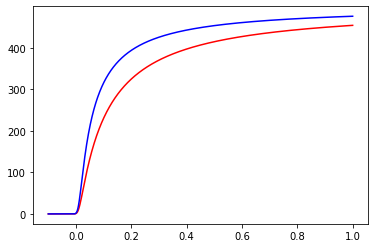

In [7]:
μs = np.linspace(-0.1,1,1001)
plt.plot(μs,φE(μs),'r')
plt.plot(μs,φI(μs),'b')

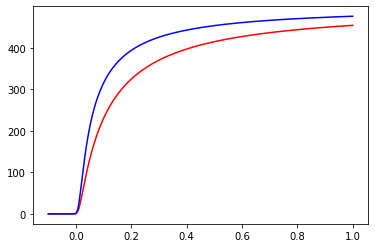

In [8]:
μs = torch.linspace(-0.1,1,1001)
plt.plot(μs,φE_torch(μs),'r')
plt.plot(μs,φI_torch(μs),'b')

# Precompute and Interpolate Opto Moments

In [9]:
set_up_backend("torch", data_type="float32")
simp = Simpson()

sr2 = np.sqrt(2)
sr2π = np.sqrt(2*np.pi)

Nint = 700001

def φLint(LNμ,LNσ,λL,μ):
    return quad(lambda x: np.exp(-0.5*((np.log(x)-LNμ)/LNσ)**2)/(sr2π*LNσ*x)*φE(μ+x)[0],0,50*λL)[0]

def MLint(LNμ,LNσ,λL,μ,Σ):
    return quad(lambda x: np.exp(-0.5*((np.log(x)-LNμ)/LNσ)**2)/(sr2π*LNσ*x)*ME(μ+x,Σ)[0],0,50*λL)[0]

def CLint(LNμ,LNσ,λL,μ,Σ,k):
    return quad(lambda x: np.exp(-0.5*((np.log(x)-LNμ)/LNσ)**2)/(sr2π*LNσ*x)*CE(μ+x,Σ,k)[0],0,50*λL)[0]

def φLint_torch(LNμ,LNσ,λL,μ):
    return simp.integrate(lambda x: torch.exp(-0.5*((torch.log(x)-LNμ)/LNσ)**2)/(sr2π*LNσ*x)*φE_torch(μ+x),
                     dim=1,N=Nint,integration_domain=[[1e-20,50*λL]],backend='torch').cpu().numpy()

def MLint_torch(LNμ,LNσ,λL,μ,Σ):
    return simp.integrate(lambda x: torch.exp(-0.5*((torch.log(x)-LNμ)/LNσ)**2)/(sr2π*LNσ*x)*ME_vecμ(μ+x,Σ),
                     dim=1,N=Nint,integration_domain=[[1e-20,50*λL]],backend='torch').cpu().numpy()

def CLint_torch(LNμ,LNσ,λL,μ,Σ,k):
    return simp.integrate(lambda x: torch.exp(-0.5*((torch.log(x)-LNμ)/LNσ)**2)/(sr2π*LNσ*x)*CE_vecμ(μ+x,Σ,k),
                     dim=1,N=Nint,integration_domain=[[1e-20,50*λL]],backend='torch').cpu().numpy()

15:39:47|TQ-WARNING| Error enabling CUDA. cuda.is_available() returned False. CPU will be used.


In [132]:
def φLitp(file,L,CVL):
    LNΣ = np.log(1+CVL**2)
    LNσ = np.sqrt(LNΣ)
    LNμ = np.log(1e-3*L)-0.5*LNΣ
        
    f = h5py.File(file, 'r')
    
    φxrange = list(f['PhLItp']['xrange'])
    φxs = np.linspace(φxrange[0],φxrange[1],round(φxrange[2]))
    
    φLs = np.zeros((len(φxs)))
    
    for x_idx,x in enumerate(φxs):
        φLs[x_idx] = φLint(LNμ,LNσ,1e3*L,xtoμ(x)*1e-3)
        
    φL_itp = RegularGridInterpolator((φxs,),φLs,bounds_error=False,fill_value=None)
    
    def φL(μ):
        try:
            return φL_itp(μtox(1e3*μ)[:,None])
        except:
            return φL_itp([μtox(1e3*μ)])
        
    return φL

def MLitp(file,L,CVL):
    LNΣ = np.log(1+CVL**2)
    LNσ = np.sqrt(LNΣ)
    LNμ = np.log(1e-3*L)-0.5*LNΣ
        
    f = h5py.File(file, 'r')
    
    Mxrange = list(f['MLItp']['xrange'])
    Mxs = np.linspace(Mxrange[0],Mxrange[1],round(Mxrange[2]))
    Mσrange = list(f['MLItp']['srange'])
    Mσs = np.linspace(Mσrange[0],Mσrange[1],round(Mσrange[2]))
    
    MLs = np.zeros((len(Mσs),len(Mxs)))
    
    for σ_idx,σ in enumerate(Mσs):
        for x_idx,x in enumerate(Mxs):
            MLs[σ_idx,x_idx] = MLint(LNμ,LNσ,1e3*L,xtoμ(x)*1e-3,(σ*1e-3)**2)
        
    ML_itp = RegularGridInterpolator((Mσs,Mxs),MLs,bounds_error=False,fill_value=None)
    
    def ML(μ,Σ):
        return ML_itp(np.vstack((1e3*np.sqrt(Σ),μtox(1e3*μ))).T)
        
    return ML

def CLitp(file,L,CVL):
    LNΣ = np.log(1+CVL**2)
    LNσ = np.sqrt(LNΣ)
    LNμ = np.log(1e-3*L)-0.5*LNΣ
        
    f = h5py.File(file, 'r')
    
    Cxrange = list(f['CLItp']['xrange'])
    Cxs = np.linspace(Cxrange[0],Cxrange[1],round(Cxrange[2]))
    Cσrange = list(f['CLItp']['srange'])
    Cσs = np.linspace(Cσrange[0],Cσrange[1],round(Cσrange[2]))
    Ccrange = list(f['CLItp']['crange'])
    Ccs = np.linspace(Ccrange[0],Ccrange[1],round(Ccrange[2]))
    
    CLs = np.zeros((len(Ccs),len(Cσs),len(Cxs)))
    
    for c_idx,c in enumerate(Ccs):
        for σ_idx,σ in enumerate(Cσs):
            for x_idx,x in enumerate(Cxs):
                CLs[c_idx,σ_idx,x_idx] = CLint(LNμ,LNσ,1e3*L,xtoμ(x)*1e-3,(σ*1e-3)**2,c*(σ*1e-3)**2)
        
    CL_itp = RegularGridInterpolator((Ccs,Cσs,Cxs),CLs,bounds_error=False,fill_value=None)
    
    def CL(μ,Σ,k):
        c = np.sign(k)*np.fmin(np.abs(k)/Σ,1)
        return CL_itp(np.vstack((c,1e3*np.sqrt(Σ),μtox(1e3*μ))).T)
        
    return CL

def opto_itp(file,L,CVL):
    LNΣ = np.log(1+CVL**2)
    LNσ = np.sqrt(LNΣ)
    LNμ = np.log(1e-3*L)-0.5*LNΣ
        
    f = h5py.File(file, 'r')
    
    opto_itp_dict = {}
    
    φxrange = list(f['PhLItp']['xrange'])
    φxs = np.linspace(φxrange[0],φxrange[1],round(φxrange[2]))
    
    φLs = np.zeros((len(φxs)))
    
    for x_idx,x in enumerate(φxs):
        φLs[x_idx] = φLint(LNμ,LNσ,1e3*L,xtoμ(x)*1e-3)
        
    φL_itp = RegularGridInterpolator((φxs,),φLs,bounds_error=False,fill_value=None)
    
    opto_itp_dict['φL_itp'] = φL_itp
    
    with open('opto_itp'+'.pkl', 'wb') as handle:
        pickle.dump(opto_itp_dict,handle)
    
    Mxrange = list(f['MLItp']['xrange'])
    Mxs = np.linspace(Mxrange[0],Mxrange[1],round(Mxrange[2]))
    Mσrange = list(f['MLItp']['srange'])
    Mσs = np.linspace(Mσrange[0],Mσrange[1],round(Mσrange[2]))
    
    MLs = np.zeros((len(Mσs),len(Mxs)))
    
    for σ_idx,σ in enumerate(Mσs):
        for x_idx,x in enumerate(Mxs):
            MLs[σ_idx,x_idx] = MLint(LNμ,LNσ,1e3*L,xtoμ(x)*1e-3,(σ*1e-3)**2)
        
    ML_itp = RegularGridInterpolator((Mσs,Mxs),MLs,bounds_error=False,fill_value=None)
    
    opto_itp_dict['ML_itp'] = ML_itp
    
    with open('opto_itp'+'.pkl', 'wb') as handle:
        pickle.dump(opto_itp_dict,handle)
    
    Cxrange = list(f['CLItp']['xrange'])
    Cxs = np.linspace(Cxrange[0],Cxrange[1],round(Cxrange[2]))
    Cσrange = list(f['CLItp']['srange'])
    Cσs = np.linspace(Cσrange[0],Cσrange[1],round(Cσrange[2]))
    Ccrange = list(f['CLItp']['crange'])
    Ccs = np.linspace(Ccrange[0],Ccrange[1],round(Ccrange[2]))
    
    CLs = np.zeros((len(Ccs),len(Cσs),len(Cxs)))
    
    for c_idx,c in enumerate(Ccs):
        for σ_idx,σ in enumerate(Cσs):
            for x_idx,x in enumerate(Cxs):
                CLs[c_idx,σ_idx,x_idx] = CLint(LNμ,LNσ,1e3*L,xtoμ(x)*1e-3,(σ*1e-3)**2,c*(σ*1e-3)**2)
        
    CL_itp = RegularGridInterpolator((Ccs,Cσs,Cxs),CLs,bounds_error=False,fill_value=None)
    
    opto_itp_dict['CL_itp'] = CL_itp
    
    with open('opto_itp'+'.pkl', 'wb') as handle:
        pickle.dump(opto_itp_dict,handle)
    
    def φL(μ):
        try:
            return φL_itp(μtox(1e3*μ)[:,None])
        except:
            return φL_itp([μtox(1e3*μ)])
    
    def ML(μ,Σ):
        return ML_itp(np.vstack((1e3*np.sqrt(Σ),μtox(1e3*μ))).T)
    
    def CL(μ,Σ,k):
        c = np.sign(k)*np.fmin(np.abs(k)/Σ,1)
        return CL_itp(np.vstack((c,1e3*np.sqrt(Σ),μtox(1e3*μ))).T)
    
    return φL,ML,CL

In [10]:
L = 2.921457296512526
CVL = 13.788965226643908
λL = 1e-3*L
LNΣ = np.log(1+CVL**2)
LNσ = np.sqrt(LNΣ)
LNμ = np.log(λL)-0.5*LNΣ

# Test Integration Times

In [11]:
start = time.time()
for i in range(100):
    φLint(LNμ,LNσ,λL,0.05)
print(φLint(LNμ,LNσ,λL,0.05))
print(time.time()-start)

137.0183643316351
31.05345106124878


In [12]:
start = time.time()
for i in range(100):
    φLint_torch(LNμ,LNσ,λL,torch.tensor(0.05))
print(φLint_torch(LNμ,LNσ,λL,torch.tensor(0.05)))
print(time.time()-start)

/usr/local/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


136.9999
6.816816091537476


In [13]:
start = time.time()
for i in range(100):
    MLint(LNμ,LNσ,λL,0.05,0.01**2)
print(MLint(LNμ,LNσ,λL,0.05,0.01**2))
print(time.time()-start)

135.4119160901201
20.22785782814026


In [14]:
start = time.time()
for i in range(100):
    MLint_torch(LNμ,LNσ,λL,torch.tensor(0.05),torch.tensor(0.01**2))
print(MLint_torch(LNμ,LNσ,λL,torch.tensor(0.05),torch.tensor(0.01**2)))
print(time.time()-start)

135.39368
12.045380115509033
